# ET Calibration Methods

In [3]:
## Notebook prep
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

import sys
code_dir = '/home/elott1/code/'
sys.path.append(code_dir)
import ColorDataUtils.CalibrationUtils as cal

data_dir = '/home/elott1/ddpi/'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

%load_ext autoreload
%autoreload 2

In [4]:
def spread_false(arr, radius=10):
    arr = arr.copy()  # Avoid modifying the original array
    false_indices = np.where(arr == False)[0]  # Find indices where it's False

    for idx in false_indices:
        left = max(0, idx - radius)
        right = min(len(arr), idx + radius + 1)
        arr[left:right] = False  # Set the range to False

    return arr
    
def print_RMSE(left, right, label='Vergence', rad=20, speed=5, buffer=10):
    
    # Filter to within _rad_ arcmin of (0,0)
    dL = np.sum(left**2, axis=1)**0.5
    dR = np.sum(right**2, axis=1)**0.5
    idx = (dL < rad) & (dR < rad)

    # Find saccades
    dsL = np.sum(np.diff(left, prepend=0, axis=0)**2, axis=1)**0.5
    dsR = np.sum(np.diff(right, prepend=0, axis=0)**2, axis=1)**0.5
    s = spread_false((dsL < speed) & (dsR < speed), buffer) # 10 ms buffer around saccs
    idx = idx & s
    
    # Caclulate means
    meanL = np.mean(left[idx], axis=0)
    meanR = np.mean(right[idx], axis=0)
    d_mean = meanL - meanR

    # Mean-adjusted filter
    left_adj = left - meanL
    right_adj = right - meanR
    dL_adj = np.sum(left_adj**2, axis=1)**0.5
    dR_adj = np.sum(right_adj**2, axis=1)**0.5
    idx_adj = (dL_adj < rad) & (dR_adj < rad) & s
    
    # Calculate original and mean-adjusted RMSE
    RMSE = np.mean((left[idx]-right[idx])**2, axis=0)**0.5
    RMSE_adj = np.mean((left_adj[idx_adj]-right_adj[idx_adj])**2, axis=0)**0.5
    
    print(f'\n{label}:')
    print(f'\t\tRMSE\tdMean\tRMSEadj')
    print(f'\tX\t{np.round(RMSE[0], 3)}\t{d_mean[0].round(3)}\t{np.round(RMSE_adj[0], 3)}')
    print(f'\tY\t{np.round(RMSE[1], 3)}\t{d_mean[1].round(3)}\t{np.round(RMSE_adj[1], 3)}\n')

## Load Plexon gain-adjusted data

In [6]:
## Load and crop plexon data
vals = np.linspace(-120, 120, 5)
Y = np.array([(x, y) for x in vals for y in vals])

plex_path = 'J250430/PlexET_ad_250430_135539_Jacomo.mat' # 04/30
plex_et, plex_sync, plex_ts = cal.load_plexon(fpath=data_dir+plex_path, gain=60)

crop = [-200, 200, -200, 200]
to_crop = (plex_et[:,0]<crop[0]) | (plex_et[:,0]>crop[1]) |\
          (plex_et[:,1]<crop[2]) | (plex_et[:,1]>crop[3]) |\
          (plex_et[:,2]<crop[0]) | (plex_et[:,2]>crop[1]) |\
          (plex_et[:,3]<crop[2]) | (plex_et[:,3]>crop[3])
plex_et = plex_et[~to_crop]

start_min = 74
end_min = 100
plex_et = plex_et[1000*60*start_min:1000*60*end_min,:]

etL, etR = plex_et[:,2:].copy(), plex_et[:,:2].copy()

In [8]:
10 * 15 0.002*2000

4.0


Vergence:
		RMSE	dMean	RMSEadj
	X	26.384	26.336	2.735
	Y	16.501	-16.494	3.073



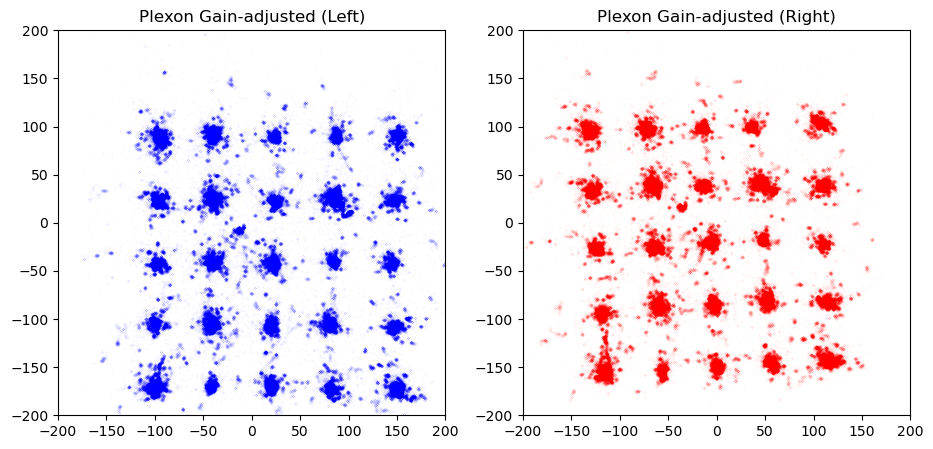

In [7]:
## Plot to ensure your loaded data makes sense
print_RMSE(etL, etR)

plt.subplots(1,2,figsize=(11,5))
plt.subplot(121)
plt.title('Plexon Gain-adjusted (Left)')
plt.scatter(etL[:,0], etL[:,1], s=0.002, alpha=0.2, c='blue')
plt.xlim(crop[0],crop[1])
plt.ylim(crop[2],crop[3])
plt.subplot(122)
plt.title('Plexon Gain-adjusted (Right)')
plt.scatter(etR[:,0], etR[:,1], s=0.002, alpha=0.2, c='red')
plt.xlim(crop[0],crop[1])
plt.ylim(crop[2],crop[3])
plt.show()

## Apply affine transformations

### Linear

In [18]:
## Run linear affine calibration (might need to play with z value to converge)
etL_cal, etL_mat = cal.align_data(etL, Y, z=2, plot=False)
etR_cal, etR_mat = cal.align_data(etR, Y, z=2, plot=False)

  Locating hotspots...

1371it [00:05, 267.14it/s]
1465it [00:05, 252.13it/s]


Done.
  Locating hotspots...

1300it [00:04, 265.77it/s]
1388it [00:05, 261.48it/s]


Done.


In [77]:
np.set_printoptions(suppress=True)
# print(etL_mat_250.round(4))
# print(etL_mat_500.round(4))
# print(etR_mat_250.round(4))
# print(etR_mat_500.round(4))
print('250 Hz')
print(f'Left offsets:\n {np.round(etL_mat_250[0],4)}')
print(f'Left gains:\n{np.round(etL_mat_250[1:],4)}\n')
print(f'Right offsets:\n {np.round(etR_mat_250[0],4)}')
print(f'Right gains:\n{np.round(etR_mat_250[1:],4)}\n\n')

print('500 Hz')
print(f'Left offsets:\n {np.round(etL_mat_500[0],4)}')
print(f'Left gains:\n{np.round(etL_mat_500[1:],4)}\n')
print(f'Right offsets:\n {np.round(etR_mat_500[0],4)}')
print(f'Right gains:\n{np.round(etR_mat_500[1:],4)}')


250 Hz
Left offsets:
 [-0.5774 -1.891 ]
Left gains:
[[ 0.9993 -0.0154]
 [-0.0034  0.9881]]

Right offsets:
 [-0.5397 -1.6335]
Right gains:
[[ 0.9957 -0.0044]
 [-0.0021  0.9869]]


500 Hz
Left offsets:
 [-0.5302 -2.5606]
Left gains:
[[ 0.9925 -0.0163]
 [-0.0001  1.0041]]

Right offsets:
 [-0.6578 -1.4255]
Right gains:
[[ 0.9989 -0.0085]
 [-0.0047  0.9921]]



Linear Affine:
		RMSE	dMean	RMSEadj
	X	3.888	-3.058	2.38
	Y	4.785	-3.657	3.069



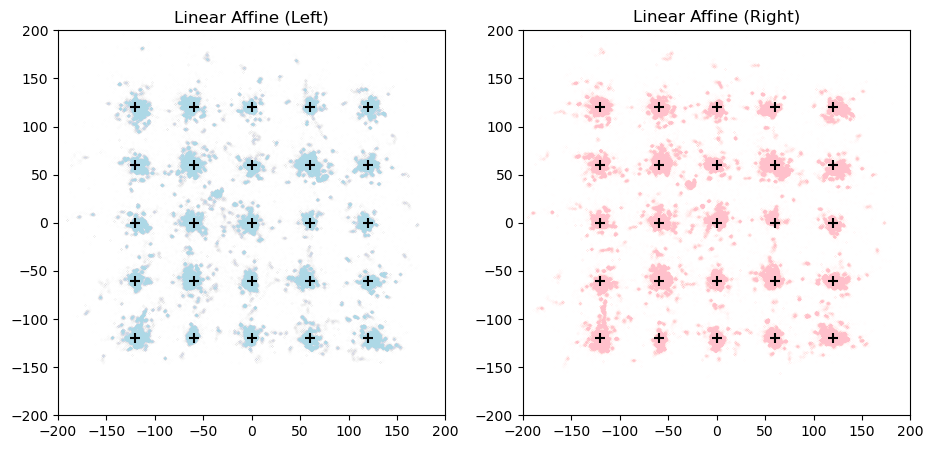

In [19]:
## Plot to ensure your calibrated data makes sense
print_RMSE(etL_cal, etR_cal, 'Linear Affine')

plt.subplots(1,2,figsize=(11,5))
plt.subplot(121)
plt.title('Linear Affine (Left)')
plt.scatter(etL_cal[:,0], etL_cal[:,1], s=0.002, alpha=0.2, c='lightblue')
plt.scatter(Y[:,0], Y[:,1], s=50, marker='+', c='k')
plt.xlim(crop[0],crop[1])
plt.ylim(crop[2],crop[3])
plt.subplot(122)
plt.title('Linear Affine (Right)')
plt.scatter(etR_cal[:,0], etR_cal[:,1], s=0.002, alpha=0.2, c='pink')
plt.scatter(Y[:,0], Y[:,1], s=50, marker='+', c='k')
plt.xlim(crop[0],crop[1])
plt.ylim(crop[2],crop[3])
plt.show()

### Nonlinear

In [20]:
## Run nonlinear affine calibration
etL_cal_NL, etL_mat_NL = cal.align_data_NL(etL, Y, z=2, plot=False)
etR_cal_NL, etR_mat_NL = cal.align_data_NL(etR, Y, z=2, plot=False)

  Locating hotspots...

1371it [00:05, 257.06it/s]
1465it [00:05, 256.73it/s]


Done.
  Locating hotspots...

1300it [00:04, 266.18it/s]
1388it [00:05, 263.37it/s]


Done.



Nonlinear Affine:
		RMSE	dMean	RMSEadj
	X	2.651	-1.077	2.397
	Y	3.762	-2.131	3.084



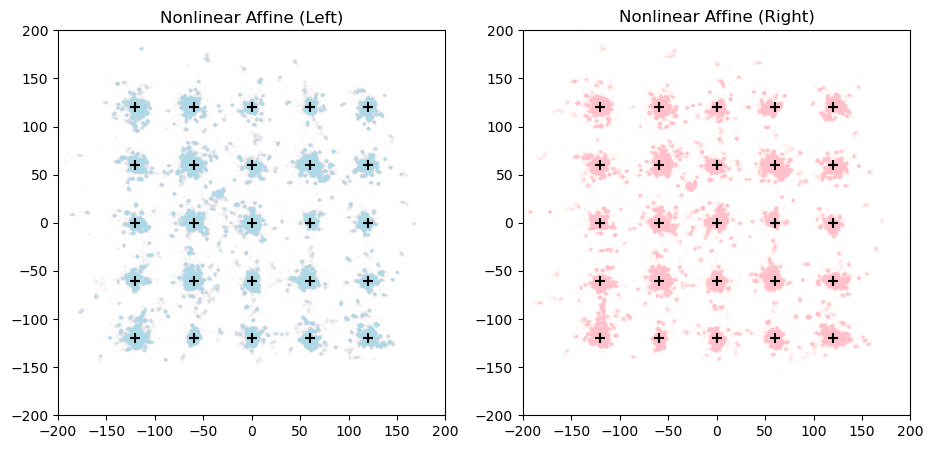

In [21]:
## Plot to ensure your calibrated data makes sense
print_RMSE(etL_cal_NL, etR_cal_NL, 'Nonlinear Affine')

plt.subplots(1,2,figsize=(11,5))
plt.subplot(121)
plt.title('Nonlinear Affine (Left)')
plt.scatter(etL_cal_NL[:,0], etL_cal_NL[:,1], s=0.002, alpha=0.2, c='lightblue')
plt.scatter(Y[:,0], Y[:,1], s=50, marker='+', c='k')
plt.xlim(crop[0],crop[1])
plt.ylim(crop[2],crop[3])
plt.subplot(122)
plt.title('Nonlinear Affine (Right)')
plt.scatter(etR_cal_NL[:,0], etR_cal_NL[:,1], s=0.002, alpha=0.2, c='pink')
plt.scatter(Y[:,0], Y[:,1], s=50, marker='+', c='k')
plt.xlim(crop[0],crop[1])
plt.ylim(crop[2],crop[3])
plt.show()

## Shifter Network

### Init and train

In [22]:
## Define dataset for ShifterNet
class ShifterDataset(Dataset):
    def __init__(self, data_points, labels):
        self.data = torch.tensor(data_points, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [23]:
## Collect training points and their labels
train_radius = 20
train_etL, train_etR = [], []
train_labs = []

for i, fix in enumerate(Y): # iterate through true fixation points
    
    # calculate distance between each frame of ET and fix_i
    dL = np.sum((etL_cal-fix)**2, axis=1)**0.5
    dR = np.sum((etR_cal-fix)**2, axis=1)**0.5
    
    # collect and label ET points within _train_radius_ arcmin
    idxL = dL < train_radius
    idxR = dR < train_radius
    idx = idxL & idxR
    train_etL.append(etL_cal[idx]) # training on ET calibrated with linear affine
    train_etR.append(etR_cal[idx])
    train_labs += [fix] * idx.sum()

train_etL = np.concatenate(train_etL)
train_etR = np.concatenate(train_etR)
train_labs = np.array(train_labs)

## Normalize training data
train_etL_norm = (train_etL - train_etL.mean()) / train_etL.std()
train_etR_norm = (train_etR - train_etR.mean()) / train_etR.std()
train_labsL_norm = (train_labs - train_etL.mean()) / train_etL.std()
train_labsR_norm = (train_labs - train_etR.mean()) / train_etR.std()

# Use dist from true point as "label"
d_etL_norm = train_labsL_norm - train_etL_norm
d_etR_norm = train_labsR_norm - train_etR_norm

# Define train/val split and dataloaders
split = (0.9, 0.1)
train_setL, val_setL = random_split(ShifterDataset(train_etL_norm, d_etL_norm), split)
train_setR, val_setR = random_split(ShifterDataset(train_etR_norm, d_etR_norm), split)

train_loadL = DataLoader(train_setL, batch_size=len(train_setL), shuffle=True)
train_loadR = DataLoader(train_setR, batch_size=len(train_setR), shuffle=True)

val_loadL = DataLoader(val_setL, batch_size=len(val_setL), shuffle=True)
val_loadR = DataLoader(val_setR, batch_size=len(val_setR), shuffle=True)

In [24]:
## Define ShifterNet
class ShifterNetwork(nn.Module):
    
    def __init__(self, hidden=20):
        super().__init__()
        self.L1 = nn.Linear(2, hidden)
        self.softplus = nn.Softplus()
        self.L2 = nn.Linear(hidden, 2)
    
    def forward(self, x):
        y = self.L2(self.softplus(self.L1(x)))
        return y

In [29]:
## Train model for left and right eye
hidden_units = 16
learning_rate = 0.1
models = (ShifterNetwork(hidden_units).to(device), ShifterNetwork(hidden_units).to(device))
loss_fn = torch.nn.MSELoss()

train_ets = (train_etL, train_etR)
train_ets_norm = (train_etL_norm, train_etR_norm)
tloaders = (train_loadL, train_loadR)
vloaders = (val_loadL, val_loadR)

epochs = 10
ets_shift = []

for eye in range(2):
    print(f'{'Left' if eye==0 else 'Right'} Eye:')
    t = tloaders[eye]
    v = vloaders[eye]
    m = models[eye]
    o = torch.optim.LBFGS(m.parameters(), lr=learning_rate)
    for e in range(epochs):
        m.train()
        for inputs, labels in t:
            def closure():
                o.zero_grad()
                outputs = m(inputs.to(device))
                tloss = loss_fn(outputs, labels.to(device))
                tloss.backward()
                return tloss
            tloss = o.step(closure)
        m.eval()
        with torch.no_grad():
            for inputs, labels in v:
                outputs = m(inputs.to(device))
                vloss = loss_fn(outputs, labels.to(device))
        print(f'\tEpoch {e+1} - train: {tloss}, val: {vloss}')
    to_pred = train_ets_norm[eye]
    et = train_ets[eye]
    pred = m(torch.tensor(to_pred, device=device, dtype=torch.float32)).detach().cpu().numpy() + to_pred # shifted ET (still normalized)
    ets_shift.append(pred * et.std() + et.mean())

modelL, modelR = models[0], models[1]
etL_shift, etR_shift = ets_shift[0], ets_shift[1]

Left Eye:
	Epoch 1 - train: 0.29866939783096313, val: 0.011184162460267544
	Epoch 2 - train: 0.01124232541769743, val: 0.0034545266535133123
	Epoch 3 - train: 0.0034702897537499666, val: 0.0031168926507234573
	Epoch 4 - train: 0.0031247318256646395, val: 0.002724178833886981
	Epoch 5 - train: 0.0027315281331539154, val: 0.0026888400316238403
	Epoch 6 - train: 0.0026978375390172005, val: 0.0026857692282646894
	Epoch 7 - train: 0.0026952431071549654, val: 0.0026845333632081747
	Epoch 8 - train: 0.0026938202790915966, val: 0.002678635763004422
	Epoch 9 - train: 0.002687461208552122, val: 0.002673911862075329
	Epoch 10 - train: 0.0026830853894352913, val: 0.0026719029992818832
Right Eye:
	Epoch 1 - train: 0.7318198084831238, val: 0.01657182164490223
	Epoch 2 - train: 0.016583647578954697, val: 0.0036745183169841766
	Epoch 3 - train: 0.003666667966172099, val: 0.003248746506869793
	Epoch 4 - train: 0.003245210973545909, val: 0.0030841187108308077
	Epoch 5 - train: 0.0030746199190616608, val


Shifter network (16 hidden units):
		RMSE	dMean	RMSEadj
	X	2.785	-1.203	2.496
	Y	3.509	-1.656	3.087



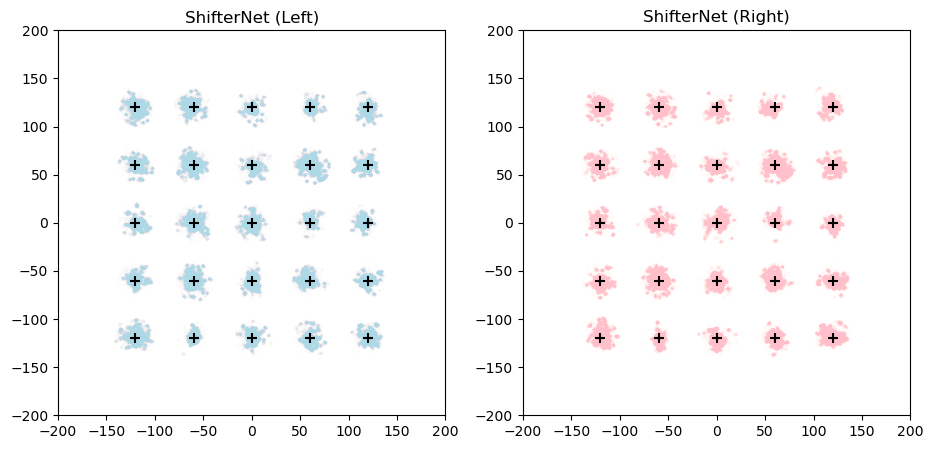

In [30]:
## Plot to ensure your shifted data makes sense
print_RMSE(etL_shift, etR_shift, f'Shifter network ({hidden_units} hidden units)')

plt.subplots(1,2,figsize=(11,5))
plt.subplot(121)
plt.title('ShifterNet (Left)')
plt.scatter(etL_shift[:,0], etL_shift[:,1], s=0.002, alpha=0.2, c='lightblue')
plt.scatter(Y[:,0], Y[:,1], s=50, marker='+', c='k')
plt.xlim(crop[0],crop[1])
plt.ylim(crop[2],crop[3])
plt.subplot(122)
plt.title('ShifterNet (Right)')
plt.scatter(etR_shift[:,0], etR_shift[:,1], s=0.002, alpha=0.2, c='pink')
plt.scatter(Y[:,0], Y[:,1], s=50, marker='+', c='k')
plt.xlim(crop[0],crop[1])
plt.ylim(crop[2],crop[3])
plt.show()

### Analyze

In [48]:
print(f'\tMSE_lin\t\tMSE_shift\tImprovement')
pre, post = 0, 0
err, mse = [], []
for eye in range(2):
    pre_error = np.sum((train_labs-train_ets[eye])**2, axis=1).mean()
    post_error = np.sum((train_labs-ets_shift[eye])**2, axis=1).mean()
    impr = (pre_error-post_error)/post_error*100
    pre += pre_error
    post += post_error
    print(f'{'Left' if eye==0 else 'Right'}:\t{pre_error.round(3)}\t\t{post_error.round(3)}\t\t{impr.round(1)}%')

    err_fix, mse_fix = [], []
    for fix in Y:
        idx_fix = (train_labs==fix).all(axis=1)
        ets_fix = ets_shift[eye][idx_fix]
        mse_fix.append(np.sum((fix-ets_fix)**2, axis=1).mean())
        err_fix.append(fix - ets_fix.mean(axis=0))
    mse.append(np.array(mse_fix).reshape(5,5).T[::-1])
    err.append(np.array(err_fix).reshape(5,5,2)[::-1])
        
impr_avg = (pre-post)/post*100
print(f'Avg:\t{(pre/2).round(3)}\t\t{(post/2).round(3)}\t\t{impr_avg.round(1)}%\n')

	MSE_lin		MSE_shift	Improvement
Left:	57.126		48.033		18.9%
Right:	45.043		42.226		6.7%
Avg:	51.085		45.129		13.2%



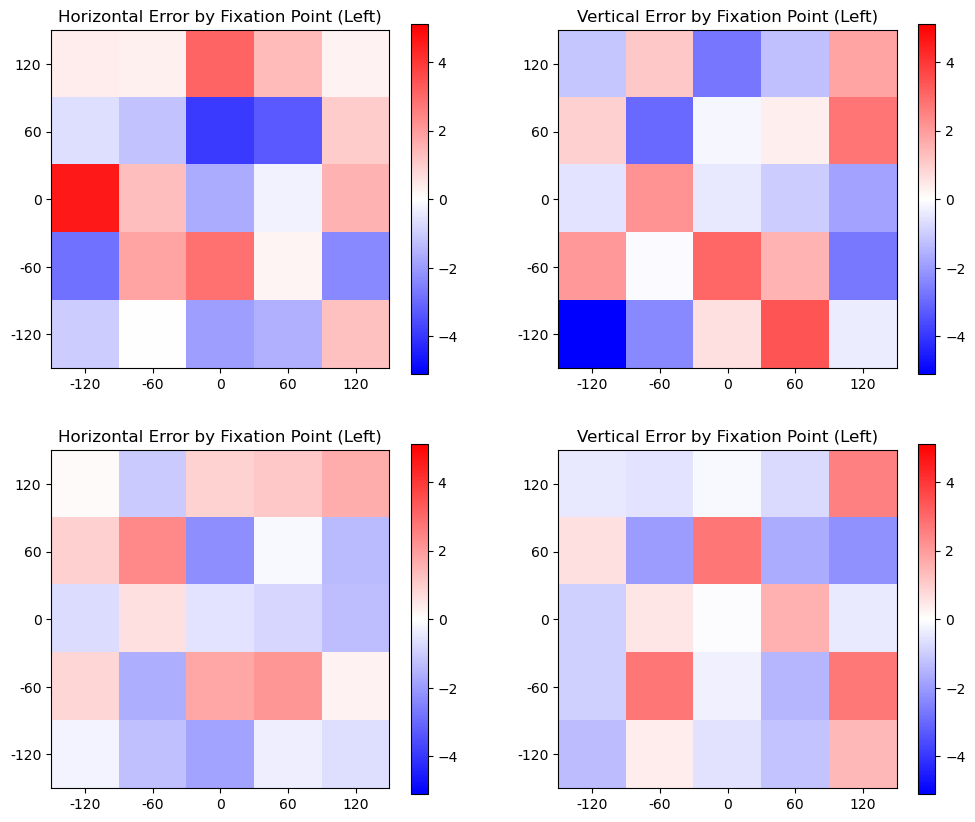

In [49]:
## Plot horizontal and vertical error of cluster means for each fixation point
cmin = min(err[0].min(), err[1].min())
cmax = max(err[0].max(), err[1].max())
lim = max(np.abs(cmin), np.abs(cmax))

plt.subplots(2,2,figsize=(12,10))
plt.subplot(221)
plt.title('Horizontal Error by Fixation Point (Left)')
plt.imshow(err[0][...,0], cmap='bwr')
plt.xticks(range(5), range(-120,121,60))
plt.yticks(range(5), range(120,-121,-60))
plt.clim(-lim, lim)
plt.colorbar()
plt.subplot(222)
plt.title('Vertical Error by Fixation Point (Left)')
plt.imshow(err[0][...,1], cmap='bwr')
plt.xticks(range(5), range(-120,121,60))
plt.yticks(range(5), range(120,-121,-60))
plt.clim(-lim, lim)
plt.colorbar()

plt.subplot(223)
plt.title('Horizontal Error by Fixation Point (Left)')
plt.imshow(err[1][...,0], cmap='bwr')
plt.xticks(range(5), range(-120,121,60))
plt.yticks(range(5), range(120,-121,-60))
plt.clim(-lim, lim)
plt.colorbar()
plt.subplot(224)
plt.title('Vertical Error by Fixation Point (Left)')
plt.imshow(err[1][...,1], cmap='bwr')
plt.xticks(range(5), range(-120,121,60))
plt.yticks(range(5), range(120,-121,-60))
plt.clim(-lim, lim)
plt.colorbar()
plt.show()

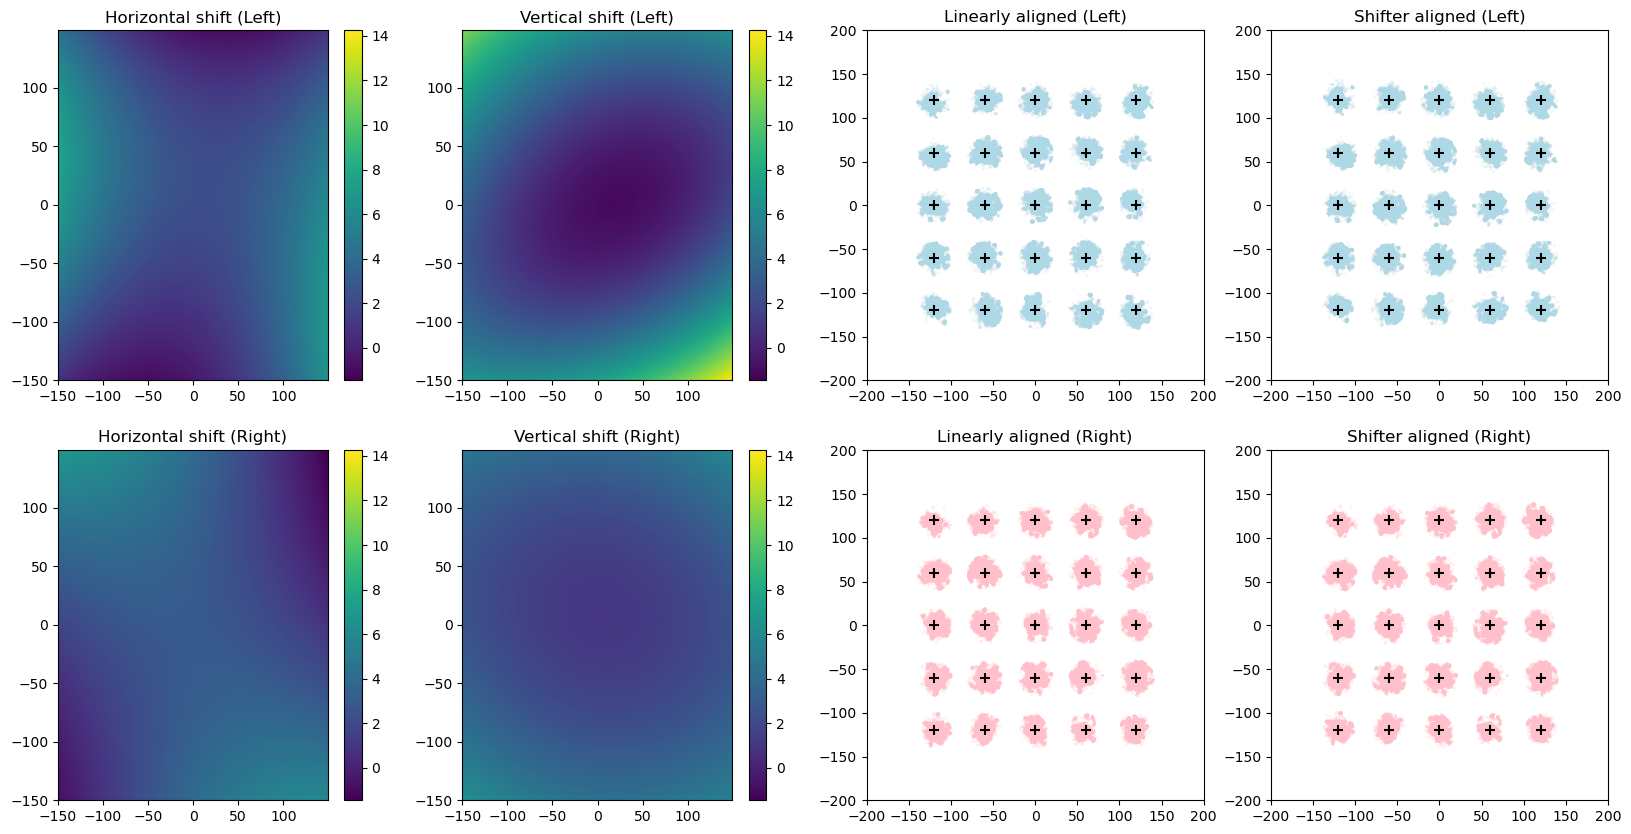

In [50]:
## Observe behavior of model
grid = np.mgrid[-150:150, -150:150].reshape(2,-1)

grid_normL = (grid - train_etL.mean()) / train_etL.std()
predL_grid = modelL(torch.tensor(grid_normL.T, device=device, dtype=torch.float32)).detach().cpu().numpy() * train_etL.std() + train_etL.mean()

grid_normR = (grid - train_etR.mean()) / train_etR.std()
predR_grid = modelR(torch.tensor(grid_normR.T, device=device, dtype=torch.float32)).detach().cpu().numpy() * train_etR.std() + train_etR.mean()

cmin = min(predL_grid.min(), predR_grid.min())
cmax = max(predL_grid.max(), predR_grid.max())
lim = max(np.abs(cmin), np.abs(cmax))

plt.subplots(2,4,figsize=(20,10))
plt.subplot(241)
plt.title('Horizontal shift (Left)')
plt.margins(0)
plt.scatter(grid[0], grid[1], s=0.5, c=predL_grid[:,0])
plt.clim(cmin, cmax)
plt.colorbar()
plt.subplot(242)
plt.title('Vertical shift (Left)')
plt.margins(0)
plt.scatter(grid[0], grid[1], s=0.5, c=predL_grid[:,1])
plt.clim(cmin, cmax)
plt.colorbar()

plt.subplot(243)
plt.scatter(train_etL[:,0], train_etL[:,1], s=0.002, c='lightblue')
plt.scatter(Y[:,0], Y[:,1], c='black', s=50, marker='+')
plt.xlim(crop[0],crop[1])
plt.ylim(crop[2],crop[3])
plt.title('Linearly aligned (Left)')
plt.subplot(244)
plt.scatter(etL_shift[:,0], etL_shift[:,1], s=0.002, c='lightblue')
plt.scatter(Y[:,0], Y[:,1], c='black', s=50, marker='+')
plt.xlim(crop[0],crop[1])
plt.ylim(crop[2],crop[3])
plt.title('Shifter aligned (Left)')

plt.subplot(245)
plt.title('Horizontal shift (Right)')
plt.margins(0)
plt.scatter(grid[0], grid[1], s=0.5, c=predR_grid[:,0])
plt.clim(cmin, cmax)
plt.colorbar()
plt.subplot(246)
plt.title('Vertical shift (Right)')
plt.margins(0)
plt.scatter(grid[0], grid[1], s=0.5, c=predR_grid[:,1])
plt.clim(cmin, cmax)
plt.colorbar()

plt.subplot(247)
plt.scatter(train_etR[:,0], train_etR[:,1], s=0.002, c='pink')
plt.scatter(Y[:,0], Y[:,1], c='black', s=50, marker='+')
plt.xlim(crop[0],crop[1])
plt.ylim(crop[2],crop[3])
plt.title('Linearly aligned (Right)')
plt.subplot(248)
plt.scatter(etR_shift[:,0], etR_shift[:,1], s=0.002, c='pink')
plt.scatter(Y[:,0], Y[:,1], c='black', s=50, marker='+')
plt.xlim(crop[0],crop[1])
plt.ylim(crop[2],crop[3])
plt.title('Shifter aligned (Right)')
plt.show()

## Method comparison

In [31]:
## Mean-adjusted error for each calibration method


methods = [
    ('Plexon Gain', etL, etR),
    ('Linear Affine', etL_cal, etR_cal),
    ('Nonlinear Affine', etL_cal_NL, etR_cal_NL),
    (f'Shifter Network ({hidden_units} units)', etL_shift, etR_shift)
]

plot = False
rad = 30
speed = 5
buffer = 10

for label, etL_i, etR_i in methods:
    
    print_RMSE(etL_i, etR_i, label)

    if plot:
        plt.subplots(2,2,figsize=(9,9))
        plt.subplot(221)
        plt.title(f'{label} - left')
        plt.scatter(etL_i[idx,0], etL_i[idx,1], s=0.5, c='b')
        plt.xlim(-rad,rad)
        plt.ylim(-rad,rad)
        plt.subplot(222)
        plt.title(f'{label} - right')
        plt.scatter(etR_i[idx,0], etR_i[idx,1], s=0.5, c='r')
        plt.xlim(-rad,rad)
        plt.ylim(-rad,rad)
        plt.subplot(223)
        plt.title(f'{label} - left_adj')
        plt.scatter(etL_i_adj[idx_adj,0], etL_i_adj[idx_adj,1], s=0.5, c='b')
        plt.xlim(-rad,rad)
        plt.ylim(-rad,rad)
        plt.subplot(224)
        plt.title(f'{label} - right_adj')
        plt.scatter(etR_i_adj[idx_adj,0], etR_i_adj[idx_adj,1], s=0.5, c='r')
        plt.xlim(-rad,rad)
        plt.ylim(-rad,rad)
        plt.show()


Plexon Gain:
		RMSE	dMean	RMSEadj
	X	26.384	26.336	2.735
	Y	16.501	-16.494	3.073


Linear Affine:
		RMSE	dMean	RMSEadj
	X	3.888	-3.058	2.38
	Y	4.785	-3.657	3.069


Nonlinear Affine:
		RMSE	dMean	RMSEadj
	X	2.651	-1.077	2.397
	Y	3.762	-2.131	3.084


Shifter Network (16 units):
		RMSE	dMean	RMSEadj
	X	2.785	-1.203	2.496
	Y	3.509	-1.656	3.087



# Investigate ET

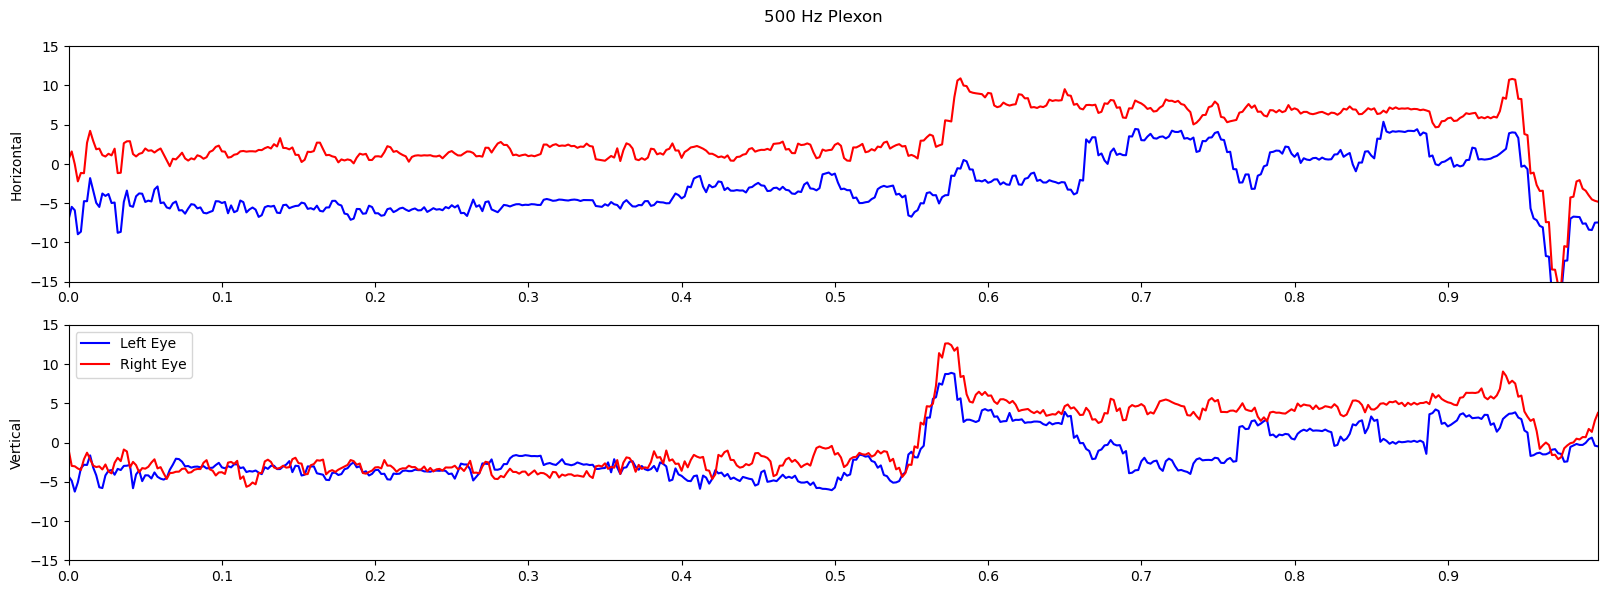

In [174]:
et = np.stack((etL_500,etR_500), axis=-1)[:500]
tr_length = et.shape[0]

fig,_ = plt.subplots(nrows=2, ncols=1)
fig.set_size_inches(16, 6)

plt.suptitle('500 Hz Plexon')
plt.tight_layout(pad=1)
cols = ['blue', 'red']
eys = ['Left Eye', 'Right Eye']
dims = ['Horizontal', 'Vertical']

mins = np.min(et,axis=0)
maxs = np.max(et,axis=0)

for dim in range(2):
    
    for eye in range(et.shape[-1]):
        x = np.arange(tr_length) * 0.002
        plt.subplot(2, 1, dim+1)
        plt.margins(x=0)
        plt.xticks(np.arange(0,x[-1],.1))
        plt.ylabel(dims[dim])
        plt.plot(x, et[:,dim,eye], color=cols[eye], label=eys[eye])
        plt.ylim(-15,15)

plt.legend()
plt.show()

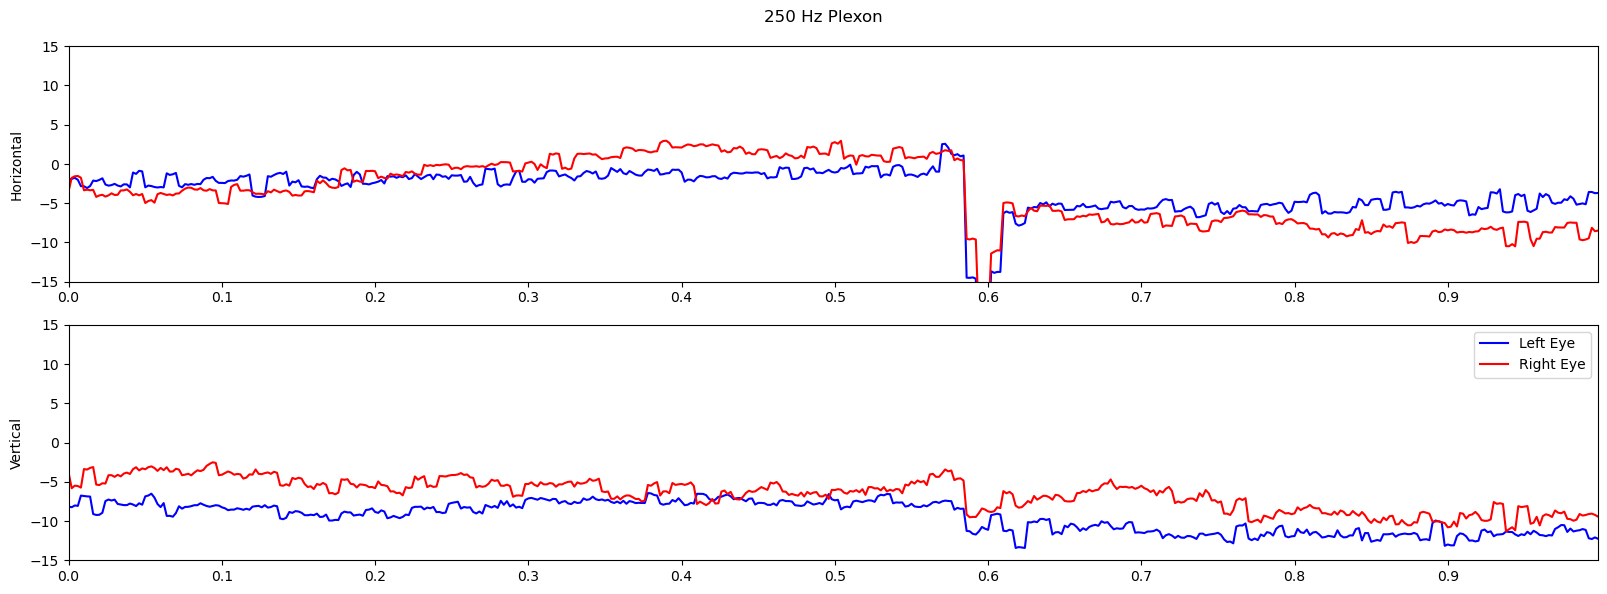

In [181]:
et = np.stack((etL_250,etR_250), axis=-1)[17050:17550]
tr_length = et.shape[0]

fig,_ = plt.subplots(nrows=2, ncols=1)
fig.set_size_inches(16, 6)

plt.suptitle('250 Hz Plexon')
plt.tight_layout(pad=1)
cols = ['blue', 'red']
eys = ['Left Eye', 'Right Eye']
dims = ['Horizontal', 'Vertical']

mins = np.min(et,axis=0)
maxs = np.max(et,axis=0)

for dim in range(2):
    
    for eye in range(et.shape[-1]):
        x = np.arange(tr_length) * 0.002
        plt.subplot(2, 1, dim+1)
        plt.margins(x=0)
        plt.xticks(np.arange(0,x[-1],.1))
        plt.ylabel(dims[dim])
        plt.plot(x, et[:,dim,eye], color=cols[eye], label=eys[eye])
        plt.ylim(-15,15)
plt.legend()
plt.show()